<a href="https://colab.research.google.com/github/junghyeon0114/python_machine/blob/main/10_CH4_10~11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**10. 스태킹 앙상블**

- 스태킹은 개별적인 여러 알고리즘을 서로 결합해 에측 결과를 도출한다는 점에서 배깅과 부스팅과의 공통점을 갖음

- 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것.

- 스태킹 모델은 두 종류의 모델이 필요
  - 개별적인 기반 모델
  - 최종 메타 모델 (개별 기반 모델의 예측 데이터를 학습데이터로 만들어서 학습)

- 스태킹 모델의 핵심 : 여러 개별 모델의 예측 데이터를 각각 스태킹 혀애로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것.

- 2~3개의 개별 모델만을 결합해서는 쉽게 예측 성능을 향상시킬 수 없음. 스태킹 적용이 반드시 성능 향상을 가져오는것은 아님.



**기본 스태킹 모델**

위스콘신 암 데이터 세트

In [1]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [2]:
# 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트/ 이들 모델의 예측 결과를 합한 데이터 세트로 학습 및 예측하는 최종 모델은 로지스틱 회귀

# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [3]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [4]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)



print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9035
에이다부스트 정확도:0.9561


In [5]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [6]:
# 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9737


**CV 세트 기반의 스태킹**

CV 세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트 이용.


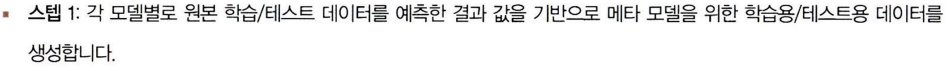


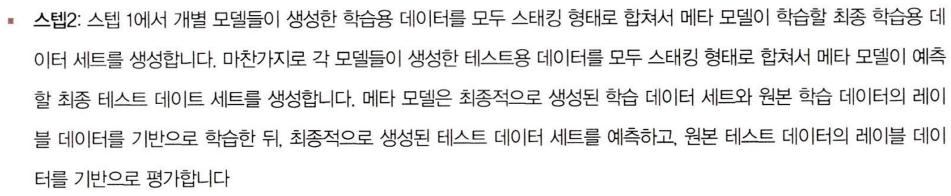

<스텝1>

첫 번째 반복 : 3개의 폴드만큼 반복 수행하면서 스태킹 데이터 생성

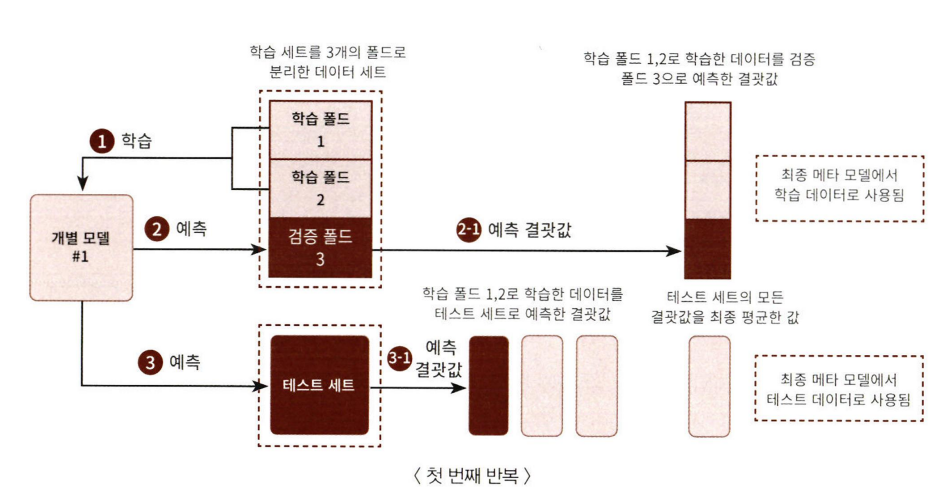

두 번째 반복 : 스태킹 데이터 생성. 폴드 내의 학습용 데이터 세트를 변경하고 첫 번째 그림과 동일한 작업 수행

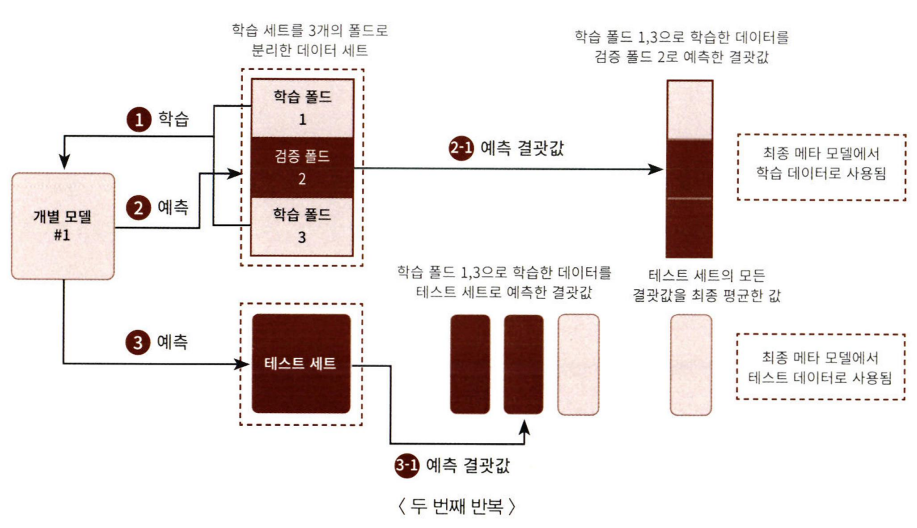

세 번째 반복: 스태킹 데이터를 생성. 폴드 내의 학습용 데이터 세트가 변경. 3번째 반복을 완료하면 첫 번째, 두 번째, 세 번째 반복을 수행하면서 만들어진 폴드별 예측 데이터를 합하여 메타 모델에서 사용될 학습 데이터를 만들게 됨.


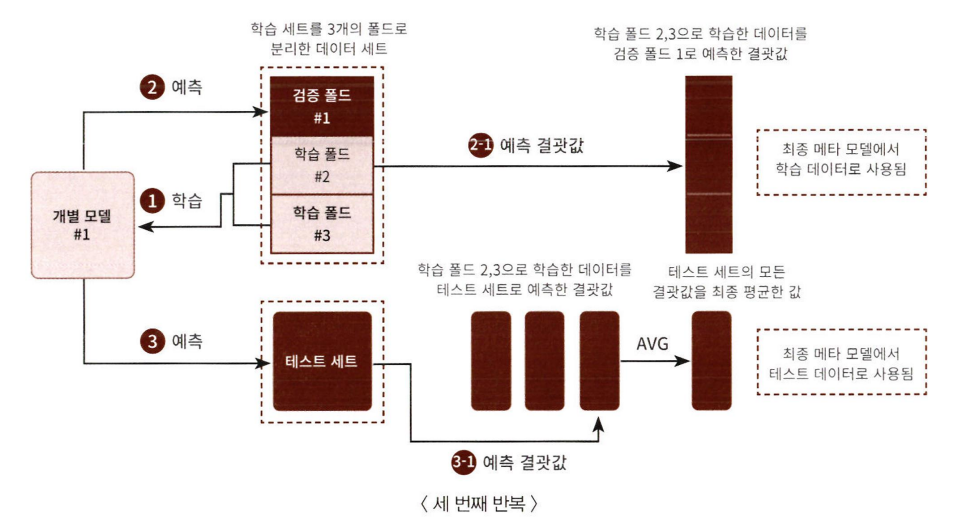

<스텝2>

각 모델들이 스텝 1로 생성한 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터오 테스트 데이터 생성.

메타 모델이 사용할 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행한 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가

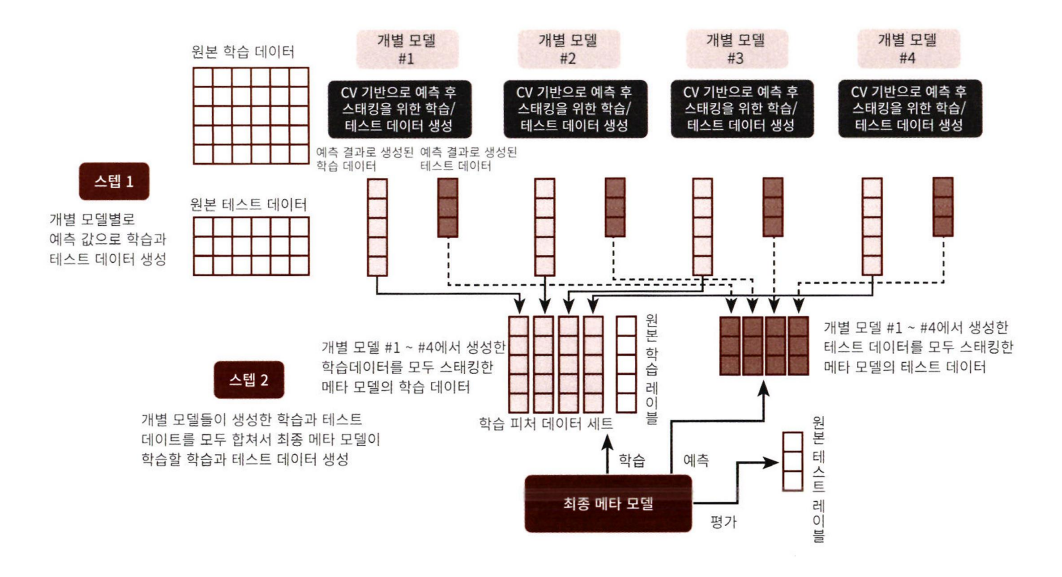

In [7]:
#스텝1 코드로 구현

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter]=model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [8]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [9]:
#스탭2
#concatenate() : 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐줌
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:' ,X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:' , Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:' ,Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [10]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


#11 정리

앙상블 기법은 대표적으로 배깅과 부스팅

1) 배깅

: 학습 데이터를 중복을 허용하며넛 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측. 대표적인 배깅 방식은 랜덤 포레스트(수행시간 빠르고 비교적 안정적인 예측 성능 제공)

2) 부스팅

: 현대는 배깅보다 부스팅이 더 주류. 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측 가능. 부스팅의 효과적인 GBM은 뛰어난 예측 성능을 갖지만 수행시간이 너무 김.

- 부스팅 기반 머신러닝에서 가장 각광 받는 패키지

  1)XGBoost

  2)LightGBM

3) 스태킹 모델

: 여러개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재 생성하는 기법. 핵심은 바로 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모데르이 예측 값들을 스태킹 형태로 결합해 생성하는 데 있음.